In [1]:
import warnings
warnings.filterwarnings('ignore')

import string
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import json

from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
from typing import Tuple
from itertools import chain
from pathlib import Path

In [2]:
plt.style.use("../figures/thesis.mplstyle")
sns.set_theme()

In [3]:
# load in the data from the excel file
df_data = pd.read_excel("../data/dvlog_transcripts.xlsx")
df_data.drop(["transcript", "transcript annotated"], axis=1, inplace=True)

df_data.head()

,video_id,label,key,gender,duration,channelId
0,0,depression,2s3EFyjUmfs,f,823.31,UCWx_Fqt2AziUyAHVjgUH1PQ
1,1,depression,MCaKQvEofrE,f,436.65,UCxxhKhiRPfPe_U78ao3FKLw
2,2,depression,6o-DlNR_cIs,m,835.83,UCCXKRG3s-auYMFIAKjeey_Q
3,3,depression,gxZjgt3Gnug,m,420.61,UCuhfaNXfRLFfVVc6dSNoyhA
4,4,depression,oc72xdTxJ50,f,444.55,UCbiKXPwk590XYYqqCEbtgoA


In [4]:
# get some overall statistics about the overall dataset
print(f"size: {len(df_data)}")

df_data.groupby("label").count()["video_id"]

size: 961


label
depression    555
normal        406
Name: video_id, dtype: int64

## Load in the Whisper transcripts


In [5]:
# get the new dataset
new_annotations_file = Path(r"../DVlog/dataset/dvlog_labels_v2.csv")
json_dir = Path(r"../data/dvlog_text")

# load in the annotation labels
df_annotations = pd.read_csv(new_annotations_file)

# set the label back to depression and normal
df_annotations["label"] = np.where(df_annotations["label"] == 1, "depression", "normal")

# get the duration of the videos
df_annotations = df_annotations.join(df_data[["video_id", "duration"]], on="video_id", rsuffix="_")
df_annotations.drop("video_id_", axis=1, inplace=True)

df_annotations.head()

,video_id,label,gender,dataset,duration
0,0,depression,f,train,823.31
1,1,depression,f,test,436.65
2,2,depression,m,train,835.83
3,3,depression,m,train,420.61
4,4,depression,f,test,444.55


In [6]:
# retrieve the text for each datapoint
text_ref_dict = {}
for json_file in os.listdir(json_dir):
    
    # get the video_id and setup the path to the file
    video_id = int(json_file.split("_")[0])
    json_path = os.path.join(json_dir, json_file)
    
    with open(json_path) as current_file:
        json_dict = json.loads(current_file.read())

    text_ref_dict[video_id] = json_dict["text"]

# put the annotations back into the dataframe
df_annotations["transcripts"] = df_annotations["video_id"].apply(lambda x: text_ref_dict.get(x))

# print the new sizes
print(f"size: {len(df_annotations)}")
print(df_annotations.groupby("label").count()["video_id"])

size: 827
label
depression    449
normal        378
Name: video_id, dtype: int64


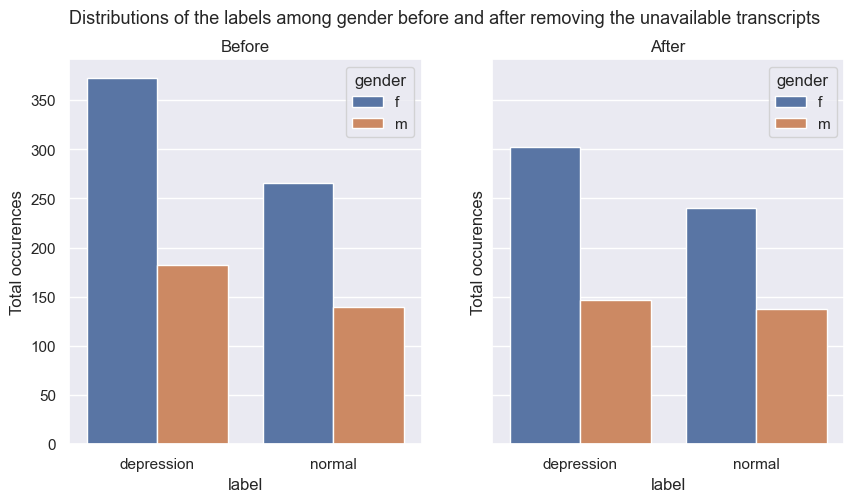

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [7]:
# Get the difference between the distributions before and after removing the transcripts
norm_data = df_data.groupby(["gender", "label"]).agg(count_occ=("video_id", "count")).reset_index()
filter_data = df_annotations.groupby(["gender", "label"]).agg(count_occ=("video_id", "count")).reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.barplot(x='label', y='count_occ', hue='gender', data=norm_data, ax=ax1)
sns.barplot(x='label', y='count_occ', hue='gender', data=filter_data, ax=ax2)

ax1.set_ylabel("Total occurences")
ax1.set_title('Before')

ax2.set_ylabel("Total occurences")
ax2.set_title('After')

fig.suptitle("Distributions of the labels among gender before and after removing the unavailable transcripts", fontsize=13)
plt.show()
fig.savefig("../figures/filtered_dvlog.eps", format="eps")

In [8]:
filter_data

,gender,label,count_occ
0,f,depression,302
1,f,normal,240
2,m,depression,147
3,m,normal,138


In [9]:
# Get the difference between the distributions of the duration
df_annotations.groupby(["label", "gender"]).agg(avg_duration=("duration", "mean"))

avg_duration
label      gender              
depression f         650.870629
           m         569.487551
normal     f         592.758625
           m         433.173841

## Going deeper into the textual modality

In [10]:
# we first have to do some basic tokenization
def preprocess_string(text: str, stop_words: set = set(stopwords.words("english")), unicode_pattern: str = "NFKD", without_stop: bool = False, with_lemma: bool = False) -> str:
    text = text.replace("\n", " ").strip()  # Remove newlines and trailing whitespace
    text = text.translate(str.maketrans("", "", string.punctuation))  # Remove puctuation with lookup table
    text = text.lower()  # Lowercase
    if without_stop:
        text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = text.translate(str.maketrans("", "", string.digits))  # Remove all numbers with lookup table
    
    # Remove excess whitespace in between words
    # E.g. the sentence "for 10 days" becomes "for days" instead of "for  days" with two spaces
    text = " ".join(text.split())
    text = unicodedata.normalize(unicode_pattern, text)  # Strip accents from characters
    
    # Lemmatization
    if with_lemma:
        lemmanizer = nltk.stem.WordNetLemmatizer()
        text = " ".join([lemmanizer.lemmatize(word) for word in text.split()])

    return text

# preprocess each string and get it with and without stop words included for further analysis
df_annotations["preprocessed_with_stop"] = df_annotations["transcripts"].apply(preprocess_string)
df_annotations["preprocessed_without_stop"] = df_annotations["transcripts"].apply(lambda x: preprocess_string(x, without_stop=True))
df_annotations["preprocessed_without_stop_with_lemma"] = df_annotations["transcripts"].apply(lambda x: preprocess_string(x, without_stop=True, with_lemma=True))
df_annotations.head(3)

,video_id,label,gender,dataset,duration,transcripts,preprocessed_with_stop,preprocessed_without_stop,preprocessed_without_stop_with_lemma
0,0,depression,f,train,823.31,So I wanted to come on here and sit down with...,so i wanted to come on here and sit down with ...,wanted come sit guys kind talk vent really str...,wanted come sit guy kind talk vent really stru...
1,1,depression,f,test,436.65,"Hello guys, it's me again and I'm going to ta...",hello guys its me again and im going to talk t...,hello guys im going talk today survive depress...,hello guy im going talk today survive depressi...
2,2,depression,m,train,835.83,Welcome back to another video today. I'm goin...,welcome back to another video today im going t...,welcome back another video today im going expl...,welcome back another video today im going expl...


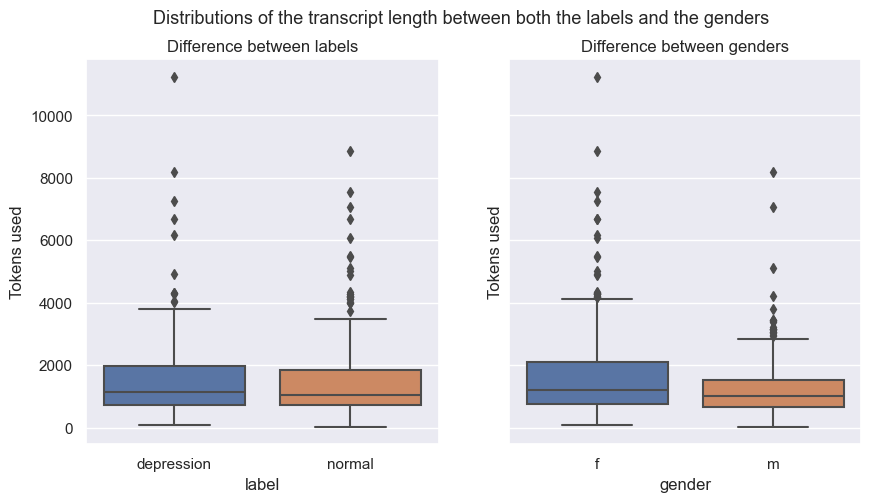

In [11]:
# Get the amount of tokens used for per gender
df_annotations["num_tokens"] = df_annotations["preprocessed_with_stop"].apply(lambda x: len(x.split()))

# plot the difference in length of the transcripts
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
sns.boxplot(x='label', y='num_tokens', data=df_annotations, ax=ax1)
sns.boxplot(x='gender', y='num_tokens', data=df_annotations, ax=ax2)

ax1.set_ylabel("Tokens used")
ax1.set_title('Difference between labels')

ax2.set_ylabel("Tokens used")
ax2.set_title('Difference between genders')

fig.suptitle("Distributions of the transcript length between both the labels and the genders", fontsize=13)
plt.show()

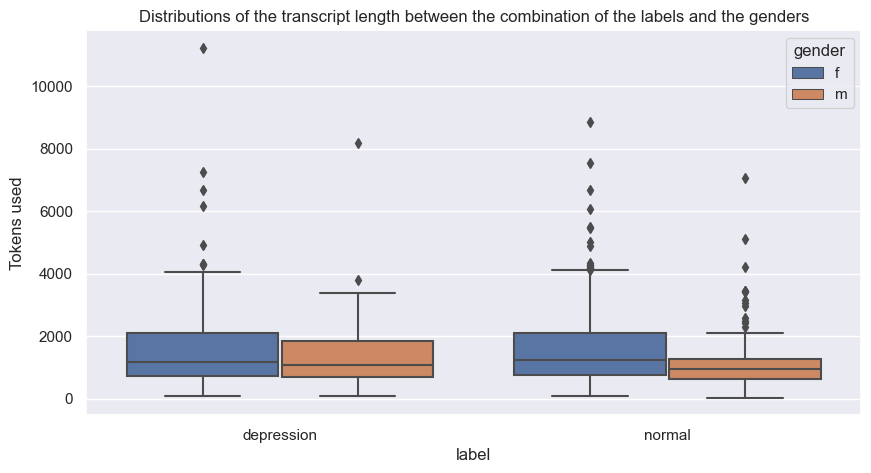

In [12]:
# plot the difference between the combination of gender and label
fig, ax = plt.subplots()
sns.boxplot(x='label', y='num_tokens', hue='gender', data=df_annotations, ax=ax)

ax.set_ylabel("Tokens used")
ax.set_title('Distributions of the transcript length between the combination of the labels and the genders')
plt.show()

### checking for specific word use using N-grams

In [13]:
def get_top_n_words(df: pd.DataFrame, column: str, n: int, col_filter: Tuple[str, str] | Tuple[str, str, str, str], ngram: int):

    if len(col_filter) == 2:
        # we specify one column and one particular value
        filtered = df[df[col_filter[0]] == col_filter[1]][column]
    else:
        # we specify two particular values from two columns
        filtered = df[(df[col_filter[0]] == col_filter[1]) & (df[col_filter[2]] == col_filter[3])][column]
    
    # put all the words to an ngram
    sequences = [sequence.split() for sequence in filtered]

    if ngram > 1:
        sequences = [list(ngrams(sequence, ngram)) for sequence in sequences]
    
    # use the Counter to count all the occurences
    counter = Counter(list(chain.from_iterable(sequences)))
    
    # return the top n words from the counter
    return counter.most_common(n)

In [14]:
# get the difference in top n words without stop words between both labels
column = "preprocessed_without_stop_with_lemma"
depr1 = get_top_n_words(df_annotations, column, 5, ("label", "depression"), 1)
depr2 = get_top_n_words(df_annotations, column, 5, ("label", "depression"), 2)

norm1 = get_top_n_words(df_annotations, column, 5, ("label", "normal"), 1)
norm2 = get_top_n_words(df_annotations, column, 5, ("label", "normal"), 2)

# put it into a dataframe
df_list = []
for depr, norm in zip(depr1, norm1):
    df_list.append(depr + norm)
for depr, norm in zip(depr2, norm2):
    df_list.append(depr + norm)

df = pd.DataFrame(df_list, columns=["depressed", "d_count", "normal", "n_count"])
df.head(10)

,depressed,d_count,normal,n_count
0,like,11252,like,8870
1,im,8347,im,5136
2,know,7469,know,4078
3,dont,4950,really,3725
4,really,4116,going,2967
5,"(dont, know)",1456,"(im, going)",1324
6,"(im, going)",1100,"(jobless, jobless)",1166
7,"(feel, like)",975,"(dont, know)",905
8,"(im, gonna)",714,"(im, gonna)",559
9,"(dont, want)",648,"(little, bit)",498


In [15]:
# get the difference in top n words without stop words between both labels combined with gender
n_gram_size = 2
column = "preprocessed_without_stop"
# column = "preprocessed_without_stop_with_lemma"

depr_f = get_top_n_words(df_annotations, column, 10, ("label", "depression", "gender", "f"), n_gram_size)
depr_m = get_top_n_words(df_annotations, column, 10, ("label", "depression", "gender", "m"), n_gram_size)

norm_f = get_top_n_words(df_annotations, column, 10, ("label", "normal", "gender", "f"), n_gram_size)
norm_m = get_top_n_words(df_annotations, column, 10, ("label", "normal", "gender", "m"), n_gram_size)

df_list = []
columns= ["depressed female", 1, "depressed male", 2, "normal female", 3, "normal male", 4]
for x1, x2, x3, x4 in zip(depr_f, depr_m, norm_f, norm_m):
    df_list.append(x1 + x2 + x3 + x4)

df = pd.DataFrame(df_list, columns=columns)
df.head(10)             

,depressed female,1,depressed male,2,normal female,3,normal male,4
0,"(dont, know)",1089,"(dont, know)",367,"(jobless, jobless)",1166,"(im, going)",438
1,"(im, going)",808,"(im, going)",292,"(im, going)",886,"(dont, know)",216
2,"(feel, like)",686,"(im, gonna)",242,"(dont, know)",689,"(going, say)",163
3,"(im, gonna)",472,"(feel, like)",187,"(im, gonna)",417,"(third, year)",160
4,"(dont, want)",464,"(know, im)",183,"(little, bit)",337,"(year, third)",158
5,"(like, im)",383,"(dont, want)",183,"(feel, like)",289,"(little, bit)",154
6,"(ive, got)",336,"(little, bit)",150,"(really, really)",204,"(say, im)",147
7,"(im, like)",331,"(like, im)",106,"(really, good)",185,"(im, gonna)",142
8,"(know, im)",328,"(ive, got)",103,"(dont, want)",177,"(nah, nah)",89
9,"(little, bit)",300,"(know, dont)",94,"(ive, got)",171,"(feel, like)",77


#### Filter out words used by other labels


In [16]:
def get_filtered_top_n_words(df: pd.DataFrame, column: str, n: int, col_filter: Tuple[str, str] | Tuple[str, str, str, str], ngram: int):
    """"""

    if len(col_filter) == 2:
        # we specify one column and one particular value
        filtered = df[df[col_filter[0]] == col_filter[1]][column]
        opposites = df[df[col_filter[0]] != col_filter[1]][column]
    else:
        # we specify two particular values from two columns
        filtered = df[(df[col_filter[0]] == col_filter[1]) & (df[col_filter[2]] == col_filter[3])][column]
        opposites = df[~((df[col_filter[0]] == col_filter[1]) & (df[col_filter[2]] == col_filter[3]))][column]

    # put all the words to an ngram
    selected_sequences = [sequence.split() for sequence in filtered]
    opposite_sequences = [sequence.split() for sequence in opposites]

    if ngram > 1:
        selected_sequences = [list(ngrams(sequence, ngram)) for sequence in selected_sequences]
        opposite_sequences = [list(ngrams(sequence, ngram)) for sequence in opposite_sequences]
    
    # filter out the unwanted words, by making the opposites a filter set
    selected_sequences = list(chain.from_iterable(selected_sequences))
    opposite_sequences = set(list(chain.from_iterable(opposite_sequences)))

    # do the filtering
    sequences = [sequence for sequence in selected_sequences if sequence not in opposite_sequences]
    
    # use the Counter to count all the occurences
    counter = Counter(sequences)
    
    # return the top n words from the counter
    return counter.most_common(n)

In [22]:
# get the difference in top n words without stop words between both labels
column = "preprocessed_without_stop_with_lemma"
# column = "preprocessed_without_stop"

depr1 = get_filtered_top_n_words(df_annotations, column, 10, ("label", "depression"), 1)
depr2 = get_filtered_top_n_words(df_annotations, column, 5, ("label", "depression"), 2)

norm1 = get_filtered_top_n_words(df_annotations, column, 10, ("label", "normal"), 1)
norm2 = get_filtered_top_n_words(df_annotations, column, 5, ("label", "normal"), 2)

# put it into a dataframe
df_list = []
for depr, norm in zip(depr1, norm1):
    df_list.append(depr + norm)
for depr, norm in zip(depr2, norm2):
    df_list.append(depr + norm)

df = pd.DataFrame(df_list, columns=["depressed", "d_count", "normal", "n_count"])
df.head(15)

,depressed,d_count,normal,n_count
0,psychiatrist,82,clemson,118
1,antidepressant,77,stereotype,78
2,selfesteem,42,tammy,58
3,worthless,33,component,57
4,counseling,33,phd,57
5,ptsd,33,concealer,44
6,counselor,28,spanish,43
7,biscuit,23,ethnicity,40
8,selfharm,22,thesis,39
9,temporary,19,korean,38


In [20]:
### get the difference in top n words without stop words between both labels combined with gender
n_gram_size = 2
column = "preprocessed_without_stop_with_lemma"
column = "preprocessed_without_stop"

depr_f = get_filtered_top_n_words(df_annotations, column, 10, ("label", "depression", "gender", "f"), n_gram_size)
depr_m = get_filtered_top_n_words(df_annotations, column, 10, ("label", "depression", "gender", "m"), n_gram_size)

norm_f = get_filtered_top_n_words(df_annotations, column, 10, ("label", "normal", "gender", "f"), n_gram_size)
norm_m = get_filtered_top_n_words(df_annotations, column, 10, ("label", "normal", "gender", "m"), n_gram_size)

df_list = []
columns= ["depressed female", 1, "depressed male", 2, "normal female", 3, "normal male", 4]
for x1, x2, x3, x4 in zip(depr_f, depr_m, norm_f, norm_m):
    df_list.append(x1 + x2 + x3 + x4)

df = pd.DataFrame(df_list, columns=columns)
df.head(10)   

,depressed female,1,depressed male,2,normal female,3,normal male,4
0,"(pen, teller)",16,"(neardeath, experience)",18,"(jobless, jobless)",1166,"(treasure, hunt)",23
1,"(im, angry)",13,"(glory, sun)",14,"(channel, welcome)",88,"(jerk, bait)",20
2,"(birth, control)",12,"(glory, glory)",12,"(people, city)",28,"(string, pattern)",19
3,"(depressed, people)",12,"(oh, santa)",9,"(peer, pressure)",26,"(assassins, creed)",17
4,"(keep, thinking)",10,"(santa, highest)",9,"(city, many)",26,"(mr, gates)",16
5,"(chronic, pain)",10,"(low, testosterone)",9,"(double, crochet)",25,"(sleep, paralysis)",13
6,"(bipolar, depression)",10,"(moving, la)",8,"(chain, one)",21,"(governing, body)",12
7,"(leave, room)",10,"(vera, juice)",8,"(cosmetology, school)",20,"(treasure, hunts)",11
8,"(going, cry)",10,"(beat, ass)",7,"(passive, voice)",18,"(student, number)",10
9,"(decis, decis)",10,"(rock, bottom)",7,"(rite, aid)",18,"(smart, drugs)",9
